In [58]:
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

First, load and preprocess the data

In [59]:
adata = sc.read_h5ad('/mnt/home/cottre61/GFP-GAT/STAGATE_pyG/SpatialTranscriptomics/151673.h5ad')
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]
adata

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 3639 × 1000
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_name', 'layer'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


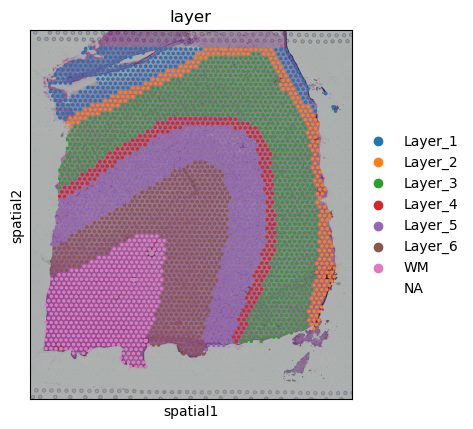

In [71]:
sc.pl.spatial(adata,color='layer',cmap='tab10')

Now, we need to construct a graph (adjacency matrix) from our spatial relations of spots on our tissue, just as we've done before. 

In [60]:
def Eu_dis(x):
    """
    Calculate the distance among each raw of x
    :param x: N X D
                N: number of samples
                D: Dimension of the feature
    :return: N X N distance matrix
    """
    x = np.asarray(x)
    aa = np.sum(np.multiply(x, x), 1)
    ab = x @ x.T
    dist_mat = aa + aa.T - 2 * ab
    dist_mat[dist_mat < 0] = 0
    dist_mat = np.sqrt(dist_mat)
    dist_mat = np.maximum(dist_mat, dist_mat.T)
    dist_mat = np.asarray(dist_mat)
    return dist_mat

def cal_adj(data, n_neighbors):
    '''
    Calculate adjacency matrix based on KNN
    For each row of X, put an edge between nodes i and j
    If nodes are among the n_neighbors nearest neighbors of each other
    according to Euclidean distance
    '''
    data = np.array(data)
    dist = Eu_dis(data)
    n = dist.shape[0]
    W_L = np.zeros((n, n))
    for i in range(n):
        index_L = np.argsort(dist[i, :])[1:1 + n_neighbors] 
        len_index_L = len(index_L)
        for j in range(len_index_L):
            W_L[i, index_L[j]] = 1 
    W_L = np.maximum(W_L, W_L.T)
    return W_L

In [61]:
coords = adata.obsm['spatial']
A = cal_adj(coords,6)
print('Spot Adjacency Matrix Shape:', A.shape)

Spot Adjacency Matrix Shape: (3639, 3639)


We can now define our Graph Convolution Network. A thorough treatment of the mathematical formulation of GCNs can be found in this blog post by one of the original authors of the GCN paper: 

I will give a brief overview here. 

A GCN layer takes as input:
- A feature matrix **X** (with dimensions *N × input_dim*, where *N* is the number of nodes (spots or cells)),
- An adjacency matrix **A** that represents the connectivity between nodes,
- And a learnable weight matrix **W**.

The goal is to perform convolution-like operations on graphs to generate a new feature representation **H**.

1. **Augment the Adjacency Matrix:**

   The layer starts by adding self-connections to **A**:
   $
   \hat{A} = A + I
   $
   where **I** is the identity matrix. This ensures that each node considers its own features during the convolution. (i.e. a spot's own expression profile should influence its embedding)

2. **Degree Matrix Calculation:**

   Compute the degree matrix **D** based on $\hat{A}$. The degree matrix is a diagonal matrix where each element $D_{ii}$ is the sum of the $i$th row of $\hat{A}$ (i.e. how many spatial neighbors that spot has, including itself).

3. **Normalization:**

   To mitigate issues with scale differences across nodes, the layer normalizes the adjacency matrix using the degree matrix:
   $
   \tilde{A} = D^{-\frac{1}{2}} \hat{A} D^{-\frac{1}{2}}
   $
   This symmetric normalization ensures that the features are scaled properly before aggregation.

4. **Feature Transformation and Aggregation:**

   The input features **X** are transformed via a learnable weight matrix **W**:
   $
   XW
   $
   The normalized adjacency matrix $\tilde{A}$ then aggregates the transformed features from each node and its neighbors:
   $
   H = \tilde{A} (XW)
   $

5. **Non-Linearity:**

   Finally, a non-linear activation function (ReLU in our case) is applied to introduce non-linearity in the embedding:
   $
   H = \text{ReLU}(\tilde{A} (XW))
   $

The final output **H** represents the new node features after the graph convolution operation- i.e. the embedding / reconstruction from that layer.



In [62]:
class GCNLayer(nn.Module):
    """
        GCN layer

        Args:
            input_dim (int): Dimension of the input (number of genes)
            output_dim (int): Dimension of the output (a softmax distribution)
            A (torch.Tensor): 2D adjacency matrix (based on spatial relations)
    """

    def __init__(self, num_nodes, input_dim: int, output_dim: int, A: torch.Tensor):
        super(GCNLayer, self).__init__()
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # A_hat = A + I
        self.A_hat = self.A + torch.eye(self.A.size(0))

        # Create diagonal degree matrix D
        self.ones = torch.ones(self.num_nodes, self.num_nodes)
        self.D = torch.matmul(self.A.float(), self.ones.float())

        # Extract the diagonal elements
        self.D = torch.diag(self.D) # creates a vector of the diagonal elements
        # Create a new tensor with the diagonal elements and zeros elsewhere
        self.D = torch.diag_embed(self.D) # create a diagonal matrix of those elements
        
        # Create D^{-1/2}
        self.D_neg_sqrt = torch.diag_embed(torch.diag(torch.pow(self.D, -0.5)))
        
        # Initialise the weight matrix as a parameter
        self.W = nn.Parameter(torch.rand(input_dim, output_dim))

    def forward(self, X: torch.Tensor):

        # D^-1/2 * (A_hat * D^-1/2)
        support_1 = torch.matmul(self.D_neg_sqrt, torch.matmul(self.A_hat, self.D_neg_sqrt))
        
        # (D^-1/2 * A_hat * D^-1/2) * (X * W)
        support_2 = torch.matmul(support_1, torch.matmul(X, self.W))
        
        # ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        H = F.relu(support_2)

        return H

We've now defined the structure of a single GCN layer. We want to stack these layers to create an autoencoder which we can use to embed and then reconstruct our data. We can conveniently do this in torch, rather than having to code it all by hand in Numpy :)

In [63]:
class GCNAutoencoder(nn.Module):
    def __init__(self, num_nodes: int, input_dim: int, hidden_dim: int, output_dim: int, A: torch.Tensor):
        """
        Args:
            input_dim (int): Dimension of the input features (number of genes).
            hidden_dim (int): Dimension of the latent space representation (embedding dimensionality).
            output_dim (int): Dimension of the output features (number of genes).
            A (torch.Tensor): Adjacency matrix of spot relations.
        """
        super(GCNAutoencoder, self).__init__()
        # Encoder: reduces dimensionality to hidden_dim
        self.encoder = GCNLayer(num_nodes, input_dim, hidden_dim, A)
        # Decoder: reconstructs the input from the latent representation
        self.decoder = GCNLayer(num_nodes, hidden_dim, output_dim, A)
        
    def forward(self, X: torch.Tensor):
        # Encode the input to a latent representation
        encoded = self.encoder(X)
        # Decode the latent representation to reconstruct the input
        decoded = self.decoder(encoded)
        return encoded, decoded

    def train_model(self, X: torch.Tensor, num_epochs: int = 1000, lr: float = 0.01):
        """
        Train the autoencoder to minimize the MSE between the input and its reconstruction.

        Args:
            X (torch.Tensor): Input feature matrix.
            num_epochs (int): Number of training epochs.
            lr (float): Learning rate for the optimizer.
        """
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            
            # Forward pass
            encoded, decoded = self(X)
            loss = criterion(decoded, X)
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

        print("Training complete.")

Now, we want to use this spatially resolved GCN autoencoder for analyzing our ST data.

In [64]:
X = adata.X
print('Gene Expression Matrix Shape:', X.shape)

Gene Expression Matrix Shape: (3639, 1000)


In [65]:
input_dim = X.shape[1]
num_nodes = X.shape[0]
hidden_dim = 30
output_dim = X.shape[1]

X = torch.tensor(X.toarray())
A = torch.tensor(A, dtype=torch.float)
I = torch.eye(A.size(0), device=A.device)
A_hat = A + I

# Initialize the autoencoder
model = GCNAutoencoder(num_nodes, input_dim, hidden_dim, output_dim, A)

# Train the model using the train_model function
model.train_model(X, num_epochs=400, lr=0.01)

# Run the model with trained parameters to get our embedding
embeddings, reconstructions = model.forward(X)

Epoch [10/400], Loss: 4425466.5000
Epoch [20/400], Loss: 1755551.3750
Epoch [30/400], Loss: 730965.5000
Epoch [40/400], Loss: 348493.4688
Epoch [50/400], Loss: 194072.0312
Epoch [60/400], Loss: 123097.7891
Epoch [70/400], Loss: 85676.4062
Epoch [80/400], Loss: 63416.8672
Epoch [90/400], Loss: 48871.8203
Epoch [100/400], Loss: 38703.5742
Epoch [110/400], Loss: 31254.8730
Epoch [120/400], Loss: 25617.9941
Epoch [130/400], Loss: 21250.8320
Epoch [140/400], Loss: 17806.2617
Epoch [150/400], Loss: 15049.9824
Epoch [160/400], Loss: 12817.6523
Epoch [170/400], Loss: 10990.6680
Epoch [180/400], Loss: 9481.5498
Epoch [190/400], Loss: 8224.6543
Epoch [200/400], Loss: 7169.9980
Epoch [210/400], Loss: 6279.0601
Epoch [220/400], Loss: 5521.8896
Epoch [230/400], Loss: 4875.0854
Epoch [240/400], Loss: 4320.2759
Epoch [250/400], Loss: 3842.6062
Epoch [260/400], Loss: 3429.7834
Epoch [270/400], Loss: 3071.4480
Epoch [280/400], Loss: 2759.0027
Epoch [290/400], Loss: 2485.4436
Epoch [300/400], Loss: 2245

Now we can see how this model performs for Spatial Domain Detection

In [66]:
adata.obsm['encoder_embedding'] = embeddings.detach().numpy()
adata.obsm['decoder_reconstruction'] = reconstructions.detach().numpy()

/tmp/ipykernel_74488/1677295846.py:1: ImplicitModificationWarning: Setting element `.obsm['encoder_embedding']` of view, initializing view as actual.
  adata.obsm['encoder_embedding'] = embeddings.detach().numpy()


Louvain is still not ideal for this data, but this is in fact typical for the Visium platform. We can instead use the Mclust clustering technique and will do so from here on out as we continue to develop better methods. 

In [67]:
from mclustpy import mclustpy
res = mclustpy(adata.obsm['encoder_embedding'], G=7, modelNames='EEE', random_seed=2020)
mclust_res = res['classification']
adata.obs['mclust'] = mclust_res

fitting ...
  |                                                                      |   0%

  |======================================================================| 100%


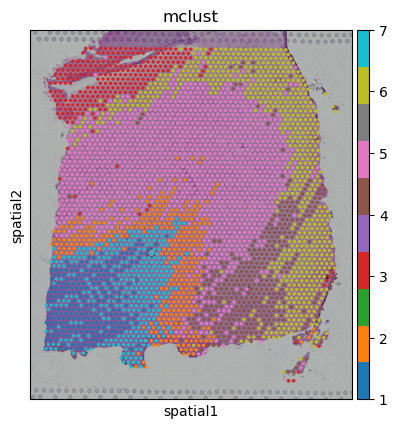

In [68]:
sc.pl.spatial(adata,color='mclust', cmap='tab10')

In [69]:
from sklearn.metrics.cluster import normalized_mutual_info_score
obs_df = adata.obs.dropna()
NMI = normalized_mutual_info_score(obs_df['mclust'],  obs_df['layer'])
print(f'Score: {NMI}')

Score: 0.4756495066008894


The result is a bit better than some of what we've seen so far, but not ideal. It's starting to detect some layer structure among the neurons, and still manages to somewhat reasonably separate the White Matter region. However, it is still not necessarily an accurate segmentation.

We note that we only used two layers in this model and didn't train it for very long (only 400 iterations). We can certainly expect some improvements by adding additional layers and letting the model run longer. We also did quite an aggressive highly variable gene selection by retaining only 1000 genes. This also likely hurts performance. The standard HVG number is usually around 3000. 

I encourage each of you to play around with this and see what results you can get in terms of NMI (keep in mind the computational limits of your computer though- you may need to run on HPCC to get good results). I would also encourage you to try different initializations for the Weight Matrices W as well as Activation Functions (such as PReLU or Sigmoid) and embedding dimensionalities (20,30,40,50,etc.). We can see who among us gets the best score next week!